# Machine Learning: Regression Case Study

#### Imports

In [1]:
%matplotlib notebook
import matplotlib.pyplot as plt
import seaborn as sns

from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter

from sklearn.linear_model import LinearRegression # just for testing

import numpy as np
import pandas as pd
import os

## Linear regression method definitions

#### Calculating Coefficients ($β_0$ and $β_1$)

The solution for the coefficients vector is:

$$\hat{β}'=(D^TD)^{-1}D^Ty$$

In [2]:
# finds beta vector given D and y   
def findCoefficients(x, y):
    x_copy = pd.DataFrame(x.values) # clone x to keep original columns
    x_copy.insert(0, 'Ones', 1)
    x_copy = np.matrix(x_copy.values)
    y = np.matrix(y.values)    
    inner = x_copy.T.dot(x_copy)
    inner_inv = np.linalg.inv(inner)
    betas = inner_inv.dot((x_copy.T.dot(y)))
    return betas

#### General simple linear regression function
A regression function for any # of variables can be generalized as $f()$ such that:

$$y=f(x_1,...,x_n)=x^Tβ+ε$$

In [3]:
# returns a function that predicts values of 'y' based on given DATAFRAME 'x'
# cat_vars is a list of tuples that represent categorical variables...
# ...with the form ("<column_name>": 0 or 1) 0 if nominal, 1 if ordinal

def getLinearRegFunc(x, y, cat_vars=[], print_betas=True):
    # deal with categorical variables
    for (col, cat) in cat_vars:
        cat_temp = pd.DataFrame(x.loc[:,col])
        # get distinct set of all possible values for categorical
        vector_values = cat_temp.loc[:,col].unique()        
        if (cat == 1): # sort values lexicographically if ordinal
            vector_values.sort()
        for index, value in enumerate(vector_values):
            x.loc[x.loc[:,col] == value, col] = index # replace old categorical var with new vector
            
    # perform linear regression normally from X' to Y
    betas = findCoefficients(x, y)
    
    if print_betas:
        print (pd.DataFrame(betas, columns=['Beta Value'])) # display betas for clarity
    
    def predict(xs):
        x_copy = pd.DataFrame(xs.values)
        x_copy.insert(0, 'Ones', 1)
        x_copy = np.matrix(x_copy.values)
        if (betas.shape[0] - x_copy.shape[1]) == 0:
            return np.matrix(x_copy).dot(betas)
        else:
            raise ValueError('data points must have exactly %d independent variables' % (betas.shape[0] - 1))
    return predict

#### Computing prediction error

The SSE here is defined as: $$Error(D)=\sum_{i=1}^m (y_i - (x_i^Tβ + ε))^2$$

In [4]:
def computeError(x, y, cat_vars=[], print_betas=1):
    reg_func = getLinearRegFunc(x, y, cat_vars, print_betas)
    inner = np.power(y - (reg_func(x)), 2)
    return np.sum(inner)

#### Backwards stepwise regression implementation
Process:
- Regress with all variables and save $error_0$
- Then try to regress using a permutation of all variables but take 1 out and compare with $error_0$ 
- if you find an error that's smaller, restart with new x but with that 1 taken out

In [5]:
errors = []

def stepwiseLinearReg(x, y):
    found = False
    min_val = computeError(x, y, [], False)[0]
    min_set = x
    
    errors.append(min_val)
    
    permutations = []
    for i in range(x.columns.size):
        permutations.append(x.drop(x.columns[i], axis = 1))
        
    for i in permutations:
        temp = computeError(i, y, [], False)[0] 
        errors.append(temp)
        if temp <= min_val:
            min_val = temp
            min_set = i
            found = True
            
    if found == True:
        print("there's a smaller one, let's get rid of one!")
        stepwiseLinearReg(min_set, y)
    else: 
        print("No smaller error, we are finished.")
        return getLinearRegFunc(x, y, [], False)

## Part 1: Univariate Case - Avg. Brain weight vs. Avg. Body weight

_Source: [Florida State University](https://people.sc.fsu.edu/~jburkardt/datasets/regression/x01.txt)_

The data records the average weight of the brain and body for a number of mammal species.

We will look into the effect that average body weight has on average brain weight.

#### Read data and prepare observed & target dataframes

In [6]:
brain_data = pd.read_csv('/home/tstan/data/brain.dat', 
                 sep='\s+', 
                 names=['index', 'brain_wt', 'body_wt'])
brain_data = brain_data.drop(['index'], axis = 1) # remove useless index column

# separate x and y to individual dfs
y = brain_data[['brain_wt']] # y
x = brain_data[['body_wt']] # X
brain_data.head()

,brain_wt,body_wt
0,3.385,44.5
1,0.480,15.5
2,1.350,8.1
3,465.000,423.0
4,36.330,119.5


#### Use above defined getLinearRegFunc() to get the regression function and display beta values

In [7]:
predict_brain_wt = getLinearRegFunc(x,y)

   Beta Value
0   10.975060
1    0.340567


'predict_brain_wt' will look like: 

$$brainweight_{predicted} = 0.34(bodyweight_{observed}) + 10.98$$
#### Check against sklearn

_(Note: we'll only do this once in this notebook for fun; I did it outside for other cases)_

In [8]:
body_wt = brain_data.iloc[:,1]
brain_wt = brain_data.iloc[:,0]
lm = LinearRegression()
lm.fit(x, brain_wt)
lm.intercept_ , lm.coef_

(10.975060401022795, array([ 0.34056726]))

#### Visualizing the model

In [9]:
xs = pd.DataFrame(np.linspace(x.min(), x.max(), 100))

<IPython.core.display.Javascript object>


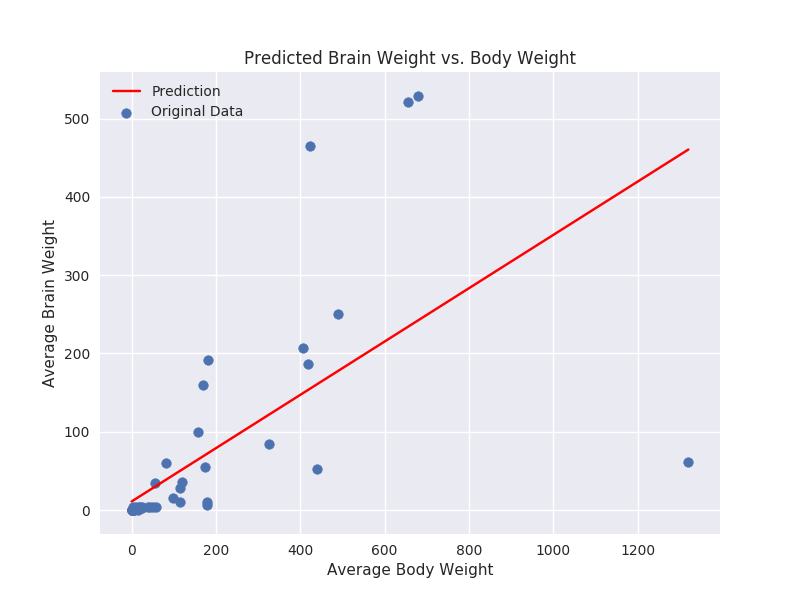

In [10]:
fig, ax = plt.subplots(figsize = (8,6))
ax.plot(xs, predict_brain_wt(xs), 'r', label='Prediction')
ax.scatter(body_wt, brain_wt, label='Original Data')
ax.legend(loc = 2)
ax.set_xlabel('Average Body Weight')
ax.set_ylabel('Average Brain Weight')
ax.set_title('Predicted Brain Weight vs. Body Weight')

#### Is it a good model?


In [11]:
dLdB = 2 * np.sum(np.matrix(x) * (y - (predict_brain_wt(x))))
dLdB

brain_wt    6.534719e-10
dtype: float64

In [12]:
computeError(x, y)

   Beta Value
0   10.975060
1    0.340567


brain_wt    485698.056623
dtype: float64

Conclusion: High variability in 'y' gives us poor fit using a linear regression but at least we can see the trend.

## Part 2: Bivariate Case - Pace of Life

The next set of data describes indicators for "the pace of life". 
- Walk = Average walking speed of pedestrian
- Bank = Average time bank teller take to make transaction
- Talk = Average talking speed of postal clerks
- Heart = Age adjusted death rates from heart disease

_Source: [R.V. Levine, "The Pace of Life", American Scientist: 450-59](http://www.pnas.org/content/104/17/7301.full)_

#### Get data

In [13]:
pace_full = pd.read_csv("/home/tstan/data/paceoflife.csv")
pace_data = pace_full[["Walk", "Talk", "Heart"]]
x = pace_data[["Walk", "Talk"]]
y = pace_data[["Heart"]]
pace_data.head()

,Walk,Talk,Heart
0,28,24,24
1,23,23,29
2,24,18,31
3,28,23,26
4,22,30,26


#### Get regression function

In [14]:
predict_heart = getLinearRegFunc(x, y)

   Beta Value
0   11.021608
1    0.429283
2   -0.019752


$$Heart_{predicted} = 11.02 + 0.43(Walk_{observed}) - 0.02(Talk_{Observed})$$
#### Attempt to visualize 3d relationship between walk rate and talk rate vs. heart disease rate

<IPython.core.display.Javascript object>


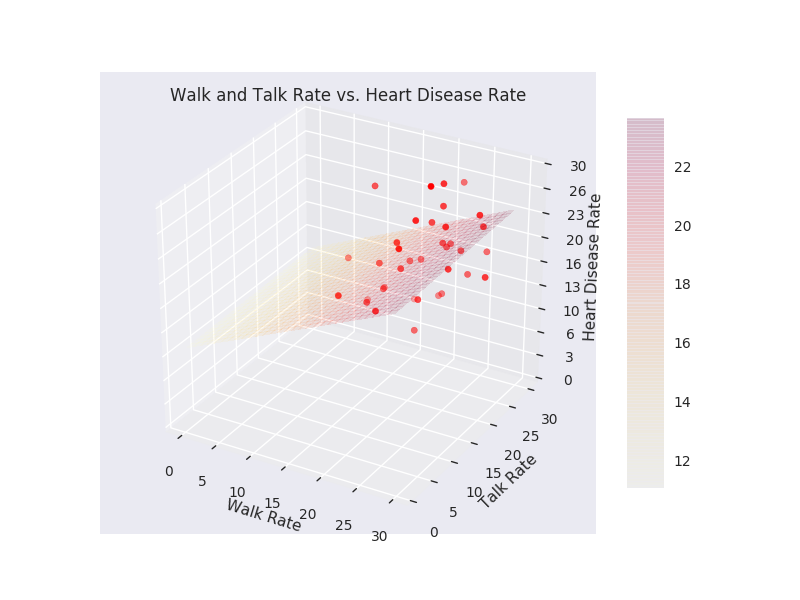

In [15]:
# build all positive integer combinations of talk and walk
pace_space = []
walk = 1
for walk in range(31):
    talk = 1
    for talk in range(31):
        pace_space.append([walk, talk])
pace_space = pd.DataFrame(pace_space, columns=["Walk", "Talk"])

# build z...???
predicted_heart = pd.DataFrame(predict_heart(pace_space))
myZ = np.ndarray(shape=(30,30))
counter = 0
idx = -1
inner = []
for i in predicted_heart.values:
    if counter == 30:
        myZ[idx] = inner
        counter = 0
        inner = []
        idx += 1
    else:
        counter += 1
        inner.append(i)

fig = plt.figure(figsize=(8,6))
ax = fig.gca(projection='3d')

X = np.arange(30, 0, -1)
Y = np.arange(0, 30, 1)
X, Y = np.meshgrid(X, Y)

ax.scatter(pace_data.Walk, pace_data.Talk, pace_data.Heart, color='Red')

surf = ax.plot_surface(Y, X, myZ, rstride=1, cstride=1, cmap=cm.YlOrRd, linewidth=0, antialiased=False, alpha = .1)
ax.set_zlim(0, 30)
ax.set_xlabel('Walk Rate')
ax.set_ylabel('Talk Rate')
ax.set_zlabel('Heart Disease Rate')
ax.set_title('Walk and Talk Rate vs. Heart Disease Rate')
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%d'))
fig.colorbar(surf, shrink=0.8, aspect=10)

plt.show()

#### Compute error

In [16]:
computeError(x, y)

   Beta Value
0   11.021608
1    0.429283
2   -0.019752


Heart    836.396135
dtype: float64

## Part 3: Multivariate Case - Red Wine quality

_Source: UCI Machine Learning Repository_

We will find the relationship between all the wine statistics vs. the perceived wine quality.

In [17]:
wine_data = pd.read_csv('/home/tstan/data/winequality/winequality-red.csv',  sep=';')
y = wine_data[['quality']]
x = wine_data
x = x.drop('quality', axis=1)
wine_data.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [18]:
computeError(x, y)

    Beta Value
0    21.965208
1     0.024991
2    -1.083590
3    -0.182564
4     0.016331
5    -1.874225
6     0.004361
7    -0.003265
8   -17.881164
9    -0.413653
10    0.916334
11    0.276198


quality    666.4107
dtype: float64

In [19]:
getLinearRegFunc(x, y, [], True)

    Beta Value
0    21.965208
1     0.024991
2    -1.083590
3    -0.182564
4     0.016331
5    -1.874225
6     0.004361
7    -0.003265
8   -17.881164
9    -0.413653
10    0.916334
11    0.276198


<function __main__.getLinearRegFunc.<locals>.predict>

"good features"
- fixed acidity
- residual sugar
- sulfur dioxide
- sulphates
- alcohol

"bad features"
- volatile acidity
- citric acid
- density
- pH

## Part 4: Multivariate + (Ordinal) Categorical Case - Housing Metrics

1. CRIM      per capita crime rate by town
3. INDUS     proportion of non-retail business acres per town
6. RM        average number of rooms per dwelling
12. B        1000(Bk - 0.63)^2 where Bk is the proportion of blacks by town
14. MEDV     Median value of owner-occupied homes in 1000 dollars

_Source: UCI Machine Learning Repository_

#### NOTE: We could use pd.Categorical with a custom comparator but these are all numerical categorical values thankfully.
i.e. ```df['m'] = pd.Categorical(df['m'], ["March", "April", "Dec"])``` 
sorts month values in order of March, april, december so you could technically pass in this comparator


Categorical case is weird. We first choose a base line $a_k$ then for each value $j\in{1,...,k-1}$ we create new vectors $a_1,...,a_{k-1}$ that look like 

$$a_1 = (1,0,0,...,0,0)$$ $$a_2 = (1,1,0,...,0,0)$$ $$a_3 = (1,1,1,0,...,0)$$ 

and so on and set $a_k$ (our base line) to a vector of all 0s. We then replace the categorical variable and perform regression with the replaced categorical variable as normal.

In [20]:
house_data = pd.read_csv('/home/tstan/data/housing.data',  sep='\s+', names=['CRIM', 'ZN','INDUS','CHAS','NOX','RM','AGE','DIS','RAD','TAX','PTRATIO','B','LSTAT','MEDV'])
x = house_data[["RM", "CRIM", "INDUS", "B"]]
x = x.round({"RM":0})  # trim for simple categorical case "RM"
y = house_data[["MEDV"]]
x.head()

,RM,CRIM,INDUS,B
0,7.0,0.00632,2.31,396.90
1,6.0,0.02731,7.07,396.90
2,7.0,0.02729,7.07,392.83
3,7.0,0.03237,2.18,394.63
4,7.0,0.06905,2.18,396.90


In [21]:
computeError(x,y,[("RM", 1)])

   Beta Value
0    2.837300
1    7.232351
2   -0.167075
3   -0.172885
4    0.016346


MEDV    18561.323697
dtype: float64

Conclusion: As expected, room number is very influential to the cost of a house.

## Part (???): Backwards Stepwise Regression - Housing metrics (continued)

In [22]:
house_data = pd.read_csv('/home/tstan/data/housing.data',  sep='\s+', names=['CRIM', 'ZN','INDUS','CHAS','NOX','RM','AGE','DIS','RAD','TAX','PTRATIO','B','LSTAT','MEDV'])
x = house_data
x = x.drop('MEDV', axis=1)
y = house_data[["MEDV"]]
x.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296.0,15.3,396.90,4.98
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242.0,17.8,396.90,9.14
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242.0,17.8,392.83,4.03
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222.0,18.7,394.63,2.94
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222.0,18.7,396.90,5.33


In [23]:
stepwiseLinearReg(x,y)

No smaller error, we are finished.


<function __main__.getLinearRegFunc.<locals>.predict>

In [24]:
errors

[11078.784577954984,
 11322.004277134598,
 11336.277557423984,
 11081.301245565057,
 11297.754935134955,
 11565.940251795715,
 12950.10865948092,
 11078.84641230837,
 12311.197070546285,
 11557.938504145372,
 11321.042017588752,
 12273.018110890129,
 11349.418808381908,
 13489.623267284736]